In [1]:
%load_ext autoreload
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import tensorflow as tf
import tensorflow.keras.backend as K
import cartopy.crs as ccrs

# my working paths
sys.path.append(r'/home/u1281808/High-res-interpretable-dl/src')
# change to the directory of the "src file" 
os.chdir(r'/home/u1281808/High-res-interpretable-dl')

from dask.diagnostics import ProgressBar
import cmocean
from models import train_model, complex_conv, simple_conv, predict, simple_dense, linear_complex_model
from losses import gamma_loss_1d, gamma_mse_metric
from prepare_data_Taiwan import format_features, prepare_training_dataset, create_test_train_split

tf.random.set_seed(2)

2025-01-07 03:01:52.161661: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 03:01:52.206992: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 03:01:52.207730: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 03:01:52.960317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [31]:
### run for the first time, skip if the combined nc exists
### Combine all .nc for high-resolution prep data
# Define the directory and filename pattern
base_dir = '/home/u1281808/High-res-interpretable-dl/training_data/'
file_pattern = 'TReAD_daily_{}_RAINNC.nc'

# Define the range of years
years = range(1980, 2022)  # From 1980 to 2021
print(years)

# Create an empty list to store datasets
datasets = []

# Loop through each year and load the corresponding .nc file
for year in years:
    file_path = os.path.join(base_dir, file_pattern.format(year))
    
    # Check if the file exists before loading
    if os.path.exists(file_path):
        # Load the dataset for the current year
        ds = xr.open_dataset(file_path)
        
        # Generate a time range with exactly 365 days, ignoring leap years
        time_range = pd.date_range(f'{year}-01-01', periods=365, freq='D')
        
        # Assign the time range to the 'Day' dimension and rename 'Day' to 'time'
        ds = ds.assign_coords(Day=time_range)
        ds = ds.rename(Day='time')

        # rename to avoid errors in the prepare_training_dataset function below
        ds = ds.rename({'Lat': 'lat', 'Lon': 'lon'})
        
        # Append to the datasets list
        datasets.append(ds)
    else:
        print(f"File not found for year {year}: {file_path}")

# Combine all datasets along the 'Day' dimension
combined_prep = xr.concat(datasets, dim='time')

# Rename RAINNC to pr
combined_prep  = combined_prep.rename({'RAINNC': 'pr'})

# Check the result to confirm the change
print(combined_prep)

# Optionally, save the combined dataset to a new .nc file
combined_prep.to_netcdf('/home/u1281808/High-res-interpretable-dl/training_data/combined_TReAD_daily_RAINNC_19802021.nc')


range(1980, 2022)
<xarray.Dataset>
Dimensions:  (time: 15330, lat: 173, lon: 101)
Coordinates:
  * lat      (lat) float32 21.88 21.9 21.92 21.94 ... 25.26 25.28 25.3 25.32
  * lon      (lon) float32 120.0 120.0 120.0 120.1 ... 121.9 122.0 122.0 122.0
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2021-12-31
Data variables:
    pr       (time, lat, lon) float32 2.563e-05 2.563e-05 ... 0.02991 0.02991


<xarray.Dataset>
Dimensions:    (time: 15330, latitude: 33, longitude: 37)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01T11:00:00 ... 2022-12-31T11:00:00
  * latitude   (latitude) float64 27.75 27.5 27.25 27.0 ... 20.25 20.0 19.75
  * longitude  (longitude) float64 116.5 116.8 117.0 117.2 ... 125.0 125.2 125.5
Data variables: (12/15)
    w850       (time, latitude, longitude) float32 ...
    q700       (time, latitude, longitude) float32 ...
    q850       (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    t500       (time, latitude, longitude) float32 ...
    t850       (time, latitude, longitude) float32 ...
    ...         ...
    v10        (time, latitude, longitude) float32 ...
    v200       (time, latitude, longitude) float32 ...
    v850       (time, latitude, longitude) float32 ...
    e          (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    tp         (time, la

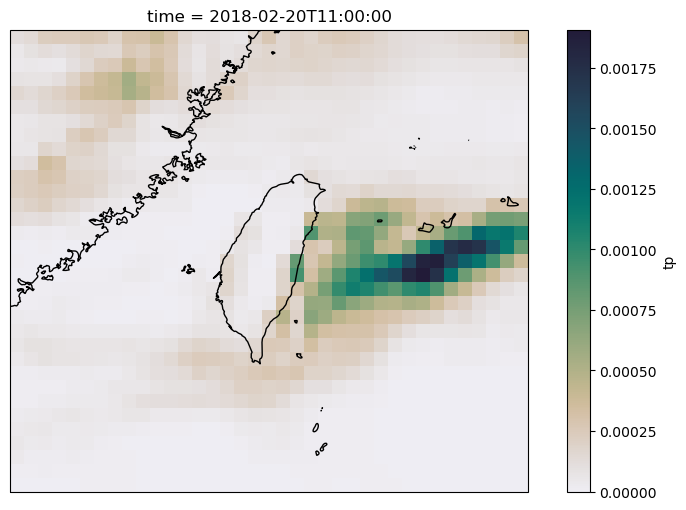

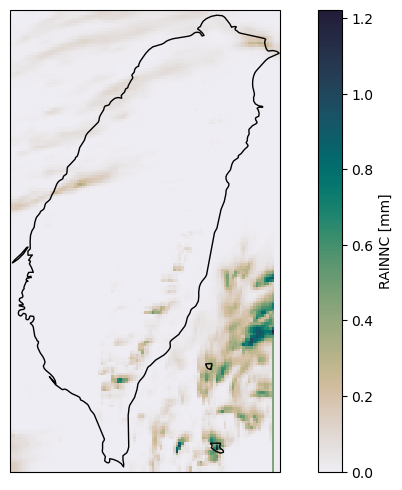

In [2]:
### display input and output data

import xarray as xr
import netCDF4 as nc
import cartopy.crs as ccrs
import cmocean  # Import cmocean to access its colormaps
import matplotlib.pyplot as plt



era5_path = '/home/u1281808/High-res-interpretable-dl/training_data/combination.nc'
ds_era5 = xr.open_dataset(era5_path)
print(ds_era5)

era5_big_path = '/home/u1281808/High-res-interpretable-dl/training_data/combination_big.nc'
ds_era5_big = xr.open_dataset(era5_big_path)
print(ds_era5_big)

# high-resolution data
dataset_path2 = '/home/u1281808/High-res-interpretable-dl/training_data/TReAD_daily_2018_RAINNC.nc'

# Open the NetCDF datasets using xarray
ds2 = xr.open_dataset(dataset_path2)

# Check the content of the datasets
print(ds2)

# Check the units for variable 'tp'
tp_units = ds_era5['tp'].attrs.get('units', 'No units specified')
print(f"Units of tp: {tp_units}")
# no unit, but ERA 5 website says meter accumulated in one hour

# Check the units for variable 'RAINNC'
rainnc_units = ds2['RAINNC'].attrs.get('units', 'No units specified')
print(f"Units of RAINNC: {rainnc_units}")
# mm

# Access the 'time' coordinate
time_values = ds_era5['time'].values[:25]

# Print all timestamps chronologically
for timestamp in time_values:
    print(timestamp)




# Plot ERA5 tp for a single time slice without lat/lon slicing to check
# 2000 is leap year
tp_day = ds_era5.sel(time="2018-02-20").tp

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Create GeoAxes with PlateCarree projection
tp_day.plot(ax=ax, vmin=0, vmax=tp_day.max(), cmap=cmocean.cm.rain, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

# day 1 has index 0
prep_day = ds2['RAINNC'].isel(Day = 50)

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Create GeoAxes with PlateCarree projection
prep_day.plot(ax=ax, vmin=0, vmax=prep_day.max(), cmap=cmocean.cm.rain, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()


In [3]:
### Select where the input and output data 
config = dict(y = "/home/u1281808/High-res-interpretable-dl/training_data/combined_TReAD_daily_RAINNC_19802021.nc",
              X = "/home/u1281808/High-res-interpretable-dl/training_data/combination.nc",
              train_start = "1981-01-01",
              train_end = "2010-12-31",
              val_start = "2011-01-01",
              val_end = "2015-12-31",
              test_start = "2016-01-01",
              test_end = "2021-12-31",
              downscale_variables = ['u850', 'v850', 'q850', 't850', 'w850'])  

x_train, x_val, x_test, y_train, y_val, y_test = create_test_train_split(config)
x_train, x_test, x_val, y_train, y_test, y_val = prepare_training_dataset(x_train, x_val, x_test, y_train, y_val, y_test)

x_train_np, x_val_np, x_test_np = x_train.values, x_val.values, x_test.values
y_train_np, y_val_np, y_test_np = y_train['pr'].values, y_val['pr'].values, y_test['pr'].values

input_shape = x_train_np.shape[1:]
output_shape = y_train_np.shape[1]


[########################################] | 100% Completed | 1.21 sms
[########################################] | 100% Completed | 1.32 sms
[########################################] | 100% Completed | 102.90 ms
[########################################] | 100% Completed | 304.06 ms
[########################################] | 100% Completed | 102.58 ms
[########################################] | 100% Completed | 505.65 ms


In [4]:
### Save data for downstream analysis
# Unstack to remove MultiIndex if it exists
y_test_reset = y_test.unstack()

# Reindex longitude (if needed) by sorting the lon values
# same as gt defined later
y_test_reset = y_test_reset.reindex(lon=sorted(y_test_reset.lon.values))
print(y_test_reset)

# Save the concatenated predictions to a NetCDF file for downstream analysis
output_path = '/home/u1281808/High-res-interpretable-dl/output_data/groundtruth_to_evalute_predictions_Taiwan.nc'  # Define the output file path
y_test_reset.to_netcdf(output_path)

print(f"Groundtruth observations saved to {output_path}")

<xarray.Dataset>
Dimensions:  (lat: 173, lon: 101, time: 2188)
Coordinates:
  * lat      (lat) float32 21.88 21.9 21.92 21.94 ... 25.26 25.28 25.3 25.32
  * lon      (lon) float32 120.0 120.0 120.0 120.1 ... 121.9 122.0 122.0 122.0
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2021-12-31
Data variables:
    pr       (time, lat, lon) float32 2.429e-07 2.429e-07 ... 0.02991 0.02991
Groundtruth observations saved to /home/u1281808/High-res-interpretable-dl/output_data/groundtruth_to_evalute_predictions_Taiwan.nc


In [9]:
### Hyperparameters and model setup using https://github.com/nram812/high-resolution-downscaling
initial_learning_rate = 1e-4
dropout = 0.6
#input_shape = x_train_np.shape[1:]  # Use the NumPy array shape for input
#output_shape = y_train_np.shape[1]  # Assuming the second dimension represents the output shape, modify if needed
hidden_layer_dense = 256
batch_size = 64
kernel_size = 5
layer_filters = [16, 32, 64]

# consistent with hyperparameter tuning
epochs = 40

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)


2024-12-13 02:01:01.251002: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-12-13 02:01:02.266114: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1794] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


In [10]:
### Define model architectures 
# While functions in models.py have predefined values for some hyperparameters, 
# the values when calling a function will override the predefined values

# linear models
linear_model = simple_dense(
    dense_layers=[hidden_layer_dense, output_shape],
    dense_activation='selu',
    input_shape=input_shape,
    dropout=dropout
)

complex_linear = linear_complex_model(
    dense_layers=[hidden_layer_dense],
    dense_activation='selu',
    input_shape=input_shape,
    dropout=dropout,
    output_shape=output_shape
)

### if spacial dimension of input is smaller than 10 x 10, set padding = 'same' instead of 'valid'
# cnn model with gamma loss
cnn_gamma = complex_conv(layer_filters=layer_filters, bn=True, padding='same', kernel_size=(kernel_size,kernel_size),
                         pooling=True, dense_layers=[hidden_layer_dense], dense_activation='selu', input_shape=input_shape,
                         dropout=dropout, activation='selu', output_shape = output_shape)

# cnn model with mse loss
simple_cnn = simple_conv(layer_filters=layer_filters, bn=True, padding='same', kernel_size=(kernel_size,kernel_size),
                         pooling=True, dense_layers=[hidden_layer_dense, output_shape], dense_activation='selu', input_shape=input_shape,
                         dropout=dropout, activation='selu')


In [11]:
### Train the model
history, model = train_model(
    complex_linear,
    [x_train_np, y_train_np],  # Use NumPy arrays for training data
    x_val = x_val_np,
    y_val = y_val_np,             # Use NumPy arrays for validation data
    # add to be consistent with other model setup
    loss = gamma_loss_1d, epochs = 40, batch_size = 64,
    optimizer = optimizer,
    model_weights_name = 'complex_linear_weights_Taiwan.h5',
    metrics = gamma_mse_metric
)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 33, 37, 5)]          0         []                            
                                                                                                  
 flatten_1 (Flatten)         (None, 6105)                 0         ['input_2[0][0]']             
                                                                                                  
 dropout_1 (Dropout)         (None, 6105)                 0         ['flatten_1[0][0]']           
                                                                                                  
 dense_2 (Dense)             (None, 256)                  1563136   ['dropout_1[0][0]']           
                                                                                            

In [12]:
# Use the legacy version of Adam optimizer to avoid error
from tensorflow.keras.optimizers import legacy
optimizer = legacy.Adam(learning_rate=0.0001)  

# CNN 
history, cnn_gamma = train_model(cnn_gamma, [x_train_np, y_train_np], x_val = x_val_np, y_val = y_val_np,
                                 loss = gamma_loss_1d, epochs = 40, batch_size = 64,
                                 optimizer = optimizer, model_weights_name = 'cnn_gamma_weights_Taiwan.h5',
                                 metrics = gamma_mse_metric)
    

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 33, 37, 5)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 33, 37, 16)           2016      ['input_3[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 16, 18, 16)           0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 batch_normalization (Batch  (None, 16, 18, 16)           64        ['average_pooling2d[0][0

In [13]:
from tensorflow.keras.optimizers import legacy
optimizer = legacy.Adam(learning_rate = 0.0001)

# linear training
history, linear_model = train_model(
    linear_model, [x_train_np, y_train_np], 
    x_val = x_val_np, y_val = y_val_np, 
    loss = 'mse', epochs = 40, batch_size = 64,
    optimizer = optimizer, model_weights_name = 'linear_weights_Taiwan.h5',
    metrics = 'mse'
)

# simple CNN training
history, simple_cnn = train_model(simple_cnn, [x_train_np, y_train_np], x_val = x_val_np, y_val = y_val_np,
                                  loss = 'mse', epochs = 40, batch_size = 64,
                                  optimizer = optimizer, model_weights_name = 'simple_cnn_weights_Taiwan.h5',
                                  metrics ='mse')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33, 37, 5)]       0         
                                                                 
 flatten (Flatten)           (None, 6105)              0         
                                                                 
 dropout (Dropout)           (None, 6105)              0         
                                                                 
 dense (Dense)               (None, 256)               1563136   
                                                                 
 dense_1 (Dense)             (None, 17473)             4490561   
                                                                 
Total params: 6053697 (23.09 MB)
Trainable params: 6053697 (23.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
171/171 [=

In [14]:
simple_cnn_prediciton = predict(simple_cnn, x_test, y_test, batch_size = 32, key = 'pr', pred_name = "test", loss = 'mse' , thres = 0.5)
simple_cnn_prediciton = simple_cnn_prediciton.unstack()
simple_cnn_prediciton = simple_cnn_prediciton.reindex(lon = sorted(simple_cnn_prediciton.lon.values))

69/69 [==============================] - 1s 9ms/step
Shape of rainfall: (2188, 17473)
Shape of data[key]: (2188, 17473)


In [15]:
simple_dense_prediction = predict(
    linear_model, 
    x_test_np,  # Use the numpy version of x_test if that's how you're training the model
    y_test,     # Keep y_test as is (no need to convert to a dataset)
    batch_size = 32, 
    key = 'pr', 
    pred_name = "test", 
    loss = 'mse', 
    thres = 0.5
)

# Continue with your post-prediction processing
simple_dense_prediction = simple_dense_prediction.unstack()
simple_dense_prediction = simple_dense_prediction.reindex(lon=sorted(simple_dense_prediction.lon.values))


69/69 [==============================] - 0s 3ms/step
Shape of rainfall: (2188, 17473)
Shape of data[key]: (2188, 17473)


In [16]:
gamma_prediciton = predict(cnn_gamma, x_test, y_test, batch_size = 32, key = 'pr', pred_name = "test", loss = 'gamma', thres = 0.5)
gamma_prediciton= gamma_prediciton.unstack()
gamma_prediciton = gamma_prediciton.reindex(lon = sorted(gamma_prediciton.lon.values))

69/69 [==============================] - 1s 14ms/step
Shape of rainfall: (2188, 17473)
Shape of data[key]: (2188, 17473)


In [17]:
complex_dense_prediciton = predict(complex_linear, x_test, y_test, batch_size = 32, key = 'pr', pred_name = "test", loss ='gamma', thres = 0.5)
complex_dense_prediciton = complex_dense_prediciton.unstack()
complex_dense_prediciton = complex_dense_prediciton.reindex(lon = sorted(complex_dense_prediciton.lon.values))

69/69 [==============================] - 1s 9ms/step
Shape of rainfall: (2188, 17473)
Shape of data[key]: (2188, 17473)


In [18]:
concat_predictions = xr.concat([simple_cnn_prediciton, simple_dense_prediction, 
                                gamma_prediciton, complex_dense_prediciton], dim ="experiments")
concat_predictions['experiments'] = (('experiments'),['simple_cnn','simple_dense', 'cnn_gamma', 'linear_gamma'])

In [19]:
### Save the concatenated predictions to a NetCDF file for downstream analysis
output_path = '/home/u1281808/High-res-interpretable-dl/output_data/combined_predictions_Taiwan.nc'  # Define the output file path
concat_predictions.to_netcdf(output_path)

print(f"Predictions saved to {output_path}")

Predictions saved to /home/u1281808/High-res-interpretable-dl/output_data/combined_predictions_Taiwan.nc


In [20]:
### Evaluate model performance
# Convert the Dataset `gt` to DataArray by selecting the appropriate variable (e.g., 'test')
gt = y_test.unstack()
gt = gt.reindex(lon = sorted(gt.lon.values))

gt_dataarray = gt['pr']  # Replace 'test' with the actual variable name if it's different

# Calculate the correlation between the ground truth and the predictions
corrs2 = xr.corr(gt_dataarray, concat_predictions.test, dim="time")

# Calculate the mean correlation over the lat and lon dimensions
mean_corr = corrs2.mean(["lat", "lon"])

# Print the result following simple_cnn, simple_dense_prediction, cnn_gamma, complex_dense
print(f"Average correlation coefficient: {mean_corr}")


Average correlation coefficient: <xarray.DataArray (experiments: 4)>
array([0.57100847, 0.61439682, 0.54350124, 0.58320316])
Coordinates:
  * experiments  (experiments) <U12 'simple_cnn' ... 'linear_gamma'


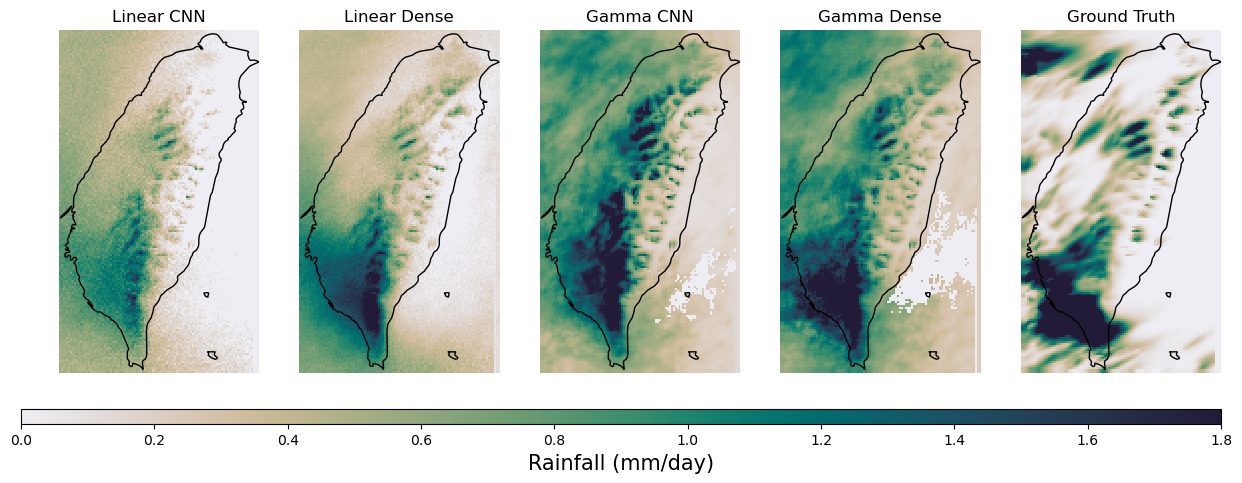

In [21]:
### Modeled precipitation comparision based on one day

date = "2018-06-20"
fig, ax = plt.subplots(1,5, figsize = (15, 5), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude = 121)))
ax = ax.ravel()
cbar_dict = dict(shrink =0.8, label = 'Daily Rainfall (mm/day)')
exps = ['simple_cnn','simple_dense', 'cnn_gamma', 'linear_gamma']

for i in range(4):
    concat_predictions.sel(time =date, experiments =exps[i])['test'].sel(lat = slice(21, 26),
                                                                            lon = slice(120, 122)).plot(vmin =0, vmax = 1.8, cmap ='cmo.rain', ax = ax[i],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree())                                            

cs = gt['pr'].sel(time =date).sel(lat = slice(21, 26),
                               lon = slice(120, 122)).plot(vmin =0, vmax = 1.8, cmap ='cmo.rain', ax = ax[-1],
                                                           add_colorbar =False,transform = ccrs.PlateCarree())          
[axes.set_title('') for axes in ax]
[axes.coastlines('10m') for axes in ax]
ax4 = fig.add_axes([0.1, 0.05, 0.8, 0.03])
cbar = fig.colorbar(cs, cax=ax4, orientation ='horizontal')
cbar.set_label('Rainfall (mm/day)', fontsize =15)
ax[0].set_title('Linear CNN')
ax[1].set_title('Linear Dense')
ax[2].set_title('Gamma CNN')
ax[3].set_title('Gamma Dense')
ax[4].set_title('Ground Truth')

def remove_spines(ax):
    ax.set_frame_on(False)
    #fig.tight_layout()
[remove_spines(axes) for axes in ax]

# Save the figure as PNG with high resolution (300 dpi)
fig.savefig('Comparison_of_simple_downscaling_methods_Taiwan_06202018.png', dpi=300)


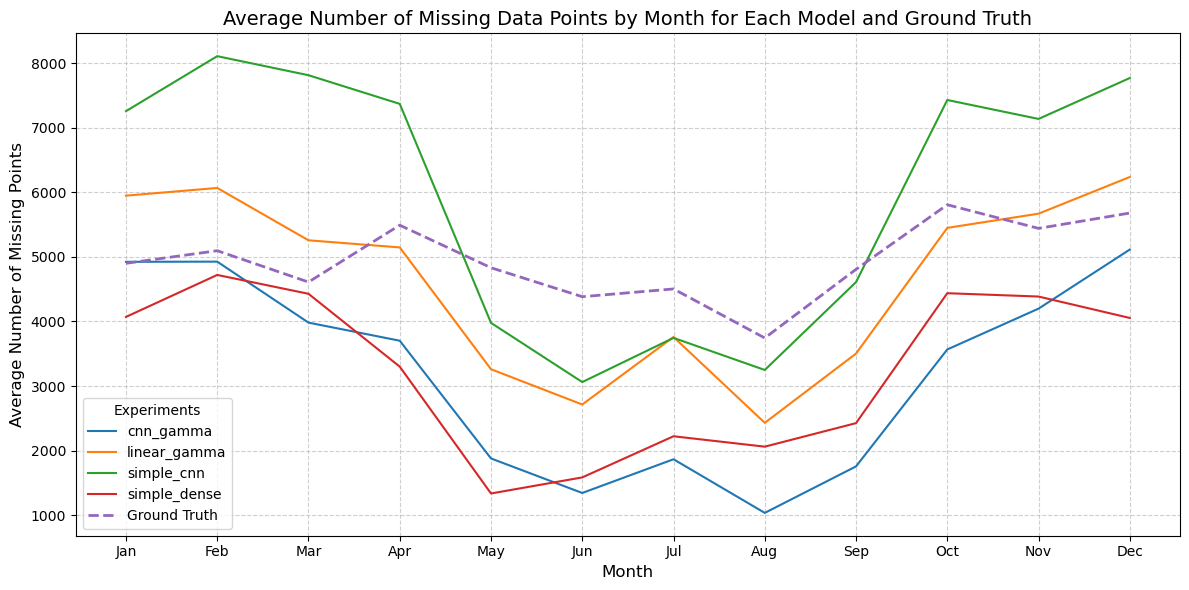

In [22]:
### seasonal cycles of a threshold 
# Define a threshold for "missing values" (assume missing if precipitation = 0)
missing_threshold = 0.0

# predicted values
# Step 1: Identify missing values for each model and day
# Create a mask where values are considered missing
missing_mask = concat_predictions['test'] <= missing_threshold  # True for missing values

# Count the number of missing data points for each day and experiment
missing_counts_daily = missing_mask.sum(dim=["lat", "lon"])

# Step 2: Prepare the dataset for monthly aggregation
# Convert to a DataFrame
missing_counts_df = missing_counts_daily.to_dataframe(name="missing_count").reset_index()

# Extract the month for grouping
missing_counts_df['month'] = missing_counts_df['time'].dt.month

# Step 3: Compute the average number of missing data points per month for each experiment
monthly_avg_missing = (
    missing_counts_df.groupby(["month", "experiments"])["missing_count"]
    .mean()
    .unstack()  # Create columns for each experiment
)

# ground truth
ground_truth_missing_mask = gt_dataarray <= missing_threshold  # True for missing values
ground_truth_missing_counts_daily = ground_truth_missing_mask.sum(dim=["lat", "lon"])
ground_truth_df = ground_truth_missing_counts_daily.to_dataframe(name="ground_truth_missing").reset_index()
ground_truth_df['month'] = ground_truth_df['time'].dt.month
ground_truth_monthly_avg = (
    ground_truth_df.groupby("month")["ground_truth_missing"].mean()
)

# gredicted values and ground truth data
combined_monthly_avg = monthly_avg_missing.copy()
combined_monthly_avg["Ground_Truth"] = ground_truth_monthly_avg



### Plot time series 
plt.figure(figsize=(12, 6))

for experiment in monthly_avg_missing.columns:
    plt.plot(combined_monthly_avg.index, combined_monthly_avg[experiment], label=experiment)

plt.plot(combined_monthly_avg.index, combined_monthly_avg["Ground_Truth"], label="Ground Truth", linestyle='--', linewidth=2)

# Customize the plot
plt.title("Average Number of Missing Data Points by Month for Each Model and Ground Truth", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Number of Missing Points", fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Experiments", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()